In [1]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

original = np.genfromtxt("./로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64).reshape(-1, 1)
original = pd.DataFrame(data=original, columns=["SEG"])
data = original.copy()
original

,SEG
0,3196231680
1,93292771632
2,93293300344
3,93293373376
4,93292057424
...,...
237191,92622695528
237192,92622695520
237193,92658792872
237194,92658792864


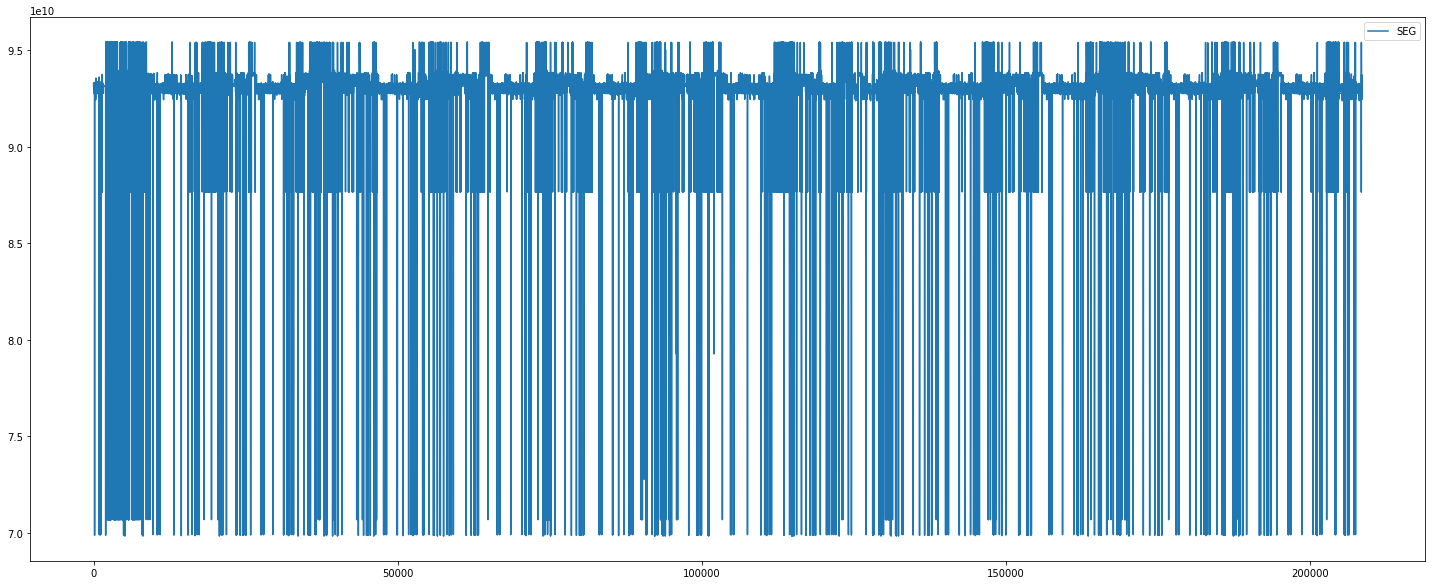

In [3]:
value_range = [(data["SEG"].max() - data["SEG"].min()) / 10 *i for i in range(10)]
docile = (data["SEG"] <= value_range[1])     # Only Remove 1st chunk of deciles
docile_index = docile.index[docile == True]

data = data.drop(index=docile_index)
data = data[28000:].reset_index(drop=True)
data.plot(figsize=(25, 10))

In [45]:
len(data)

208501

In [4]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data))-step)])
    return delta

In [5]:
pattern_length = 4

delta = delta_slice(data, pattern_length)
delta

,SEG
0,432584
1,-21321705
2,-56053462
3,87057360
4,-101953016
...,...
208492,29537720
208493,11427864
208494,47525224
208495,-75277398


In [6]:
split_index = 190000
train_set = delta[:split_index]
test_set = delta[split_index:]
test_set.reset_index(drop=True, inplace=True)
train_set, test_set

(              SEG
 0          432584
 1       -21321705
 2       -56053462
 3        87057360
 4      -101953016
 ...           ...
 189995    8497752
 189996    4514130
 189997    4938572
 189998   -8385412
 189999    6033432
 
 [190000 rows x 1 columns],
             SEG
 0       2985022
 1      -9098444
 2       7605476
 3      -8908504
 4      44216784
 ...         ...
 18492  29537720
 18493  11427864
 18494  47525224
 18495 -75277398
 18496  32291664
 
 [18497 rows x 1 columns])

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

train_data_scaled = std_scaler.fit_transform(train_set.values)
train_data_scaled, std_scaler.mean_, std_scaler.var_

(array([[ 0.00014998],
        [-0.00739914],
        [-0.01945168],
        ...,
        [ 0.00171364],
        [-0.00291002],
        [ 0.00209358]]),
 array([376.06845789]),
 array([8.30417512e+18]))

In [94]:
def generate_timeseries(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels)

In [9]:
PAST_HISTORY = 16
FUTURE_TARGET = 8
TRAIN_SPLIT = 170000
BATCH_SIZE = 256
BUFFER_SIZE = 200000

In [10]:
x_train, y_train = generate_timeseries(train_data_scaled, 0, TRAIN_SPLIT, PAST_HISTORY, FUTURE_TARGET)
x_val, y_val = generate_timeseries(train_data_scaled, TRAIN_SPLIT, None, PAST_HISTORY, FUTURE_TARGET)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [11]:
def plot_graphs(history, metric, title=None):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    if title:
        plt.savefig("result/{0}-{1}.png".format(metric, title), dpi=300)
    plt.show()    

In [12]:
num_neurons_1 = 128
num_neurons_2 = 128
dropout_rate = 0.2

EPOCHS = 1000
EVALUATION_INTERVAL = 500
VAL_STEPS = 50
title = '{0}-{1}-{2}_{3}'.format(EPOCHS, BATCH_SIZE, num_neurons_1, num_neurons_2)

In [66]:
import joblib

joblib.dump(std_scaler, "models/std-scaler_{0}.pkl".format(title))

['models/std-scaler_1000-256-128_128.pkl']

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(num_neurons_1, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(num_neurons_2))
model.add(tf.keras.layers.Dense(FUTURE_TARGET))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [14]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=VAL_STEPS, callbacks=[tensorboard_callback])

0.2628
Epoch 854/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2607 - val_mse: 0.2607
Epoch 855/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2769 - mse: 0.2769 - val_loss: 0.2655 - val_mse: 0.2655
Epoch 856/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2795 - mse: 0.2795 - val_loss: 0.2671 - val_mse: 0.2671
Epoch 857/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2837 - mse: 0.2837 - val_loss: 0.2634 - val_mse: 0.2634
Epoch 858/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2950 - mse: 0.2950 - val_loss: 0.2652 - val_mse: 0.2652
Epoch 859/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2937 - mse: 0.2937 - val_loss: 0.2653 - val_mse: 0.2653
Epoch 860/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.2976 - mse: 0.2976 - val_loss: 0.2609 - val_mse: 0.2609
Epoch 861/1000
500/500 [=================

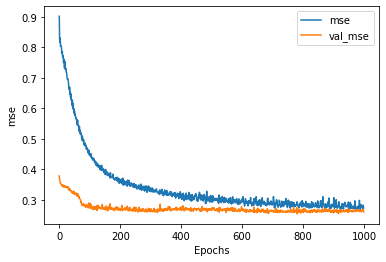

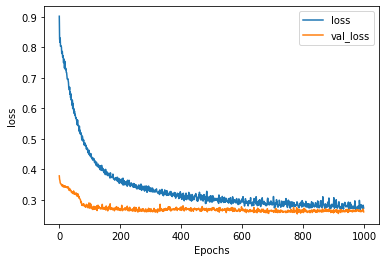

In [15]:
pd.DataFrame.from_dict(model_history.history).to_csv("result/{0}.csv".format(title), index=False)
plot_graphs(model_history, 'mse', title)
plot_graphs(model_history, 'loss', title)

In [21]:
model.save("models/{0}.h5".format(title))

In [22]:
new_model = keras.models.load_model("models/{0}.h5".format(title))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
Total params: 199,176
Trainable params: 199,176
Non-trainable params: 0
_________________________________________________________________


In [24]:
new_model.predict(x_test[0].reshape(1, -1, 1))

array([[ 0.00306705,  0.03327849, -0.07215234,  0.03681722,  0.03646787,
        -0.01121287,  0.04027897,  0.00254766]], dtype=float32)

In [16]:
test_data = delta_slice(test_set, pattern_length)
test_data_nomalized = std_scaler.transform(test_data)
x_test, y_test = generate_timeseries(test_data_nomalized, 0, None, PAST_HISTORY, FUTURE_TARGET)

In [39]:
from sklearn.metrics import mean_squared_error

def plot_test_error(model, x_test, y_test, title=None):
    test_preds = []
    test_errors = []
    for x, y in zip(x_test, y_test):
        x_pred = model.predict(x.reshape(1, -1, 1))
        test_preds.append(x_pred)
        test_errors.append(mean_squared_error(y.reshape(1, -1), x_pred))
    test_errors = pd.DataFrame(data=[test_errors]).T
    test_errors.columns = ["Test MSE"]
    test_plot = test_errors.plot(figsize=(25, 10))
    test_plot.set_ylim(0, 0.04)
    if title:
        test_errors.to_csv("result/test_mse-{0}.csv".format(title), index=False)
        test_plot.figure.savefig("result/test_mse-{0}.png".format(title), dpi=300)
    plt.show()
    return test_preds, test_errors

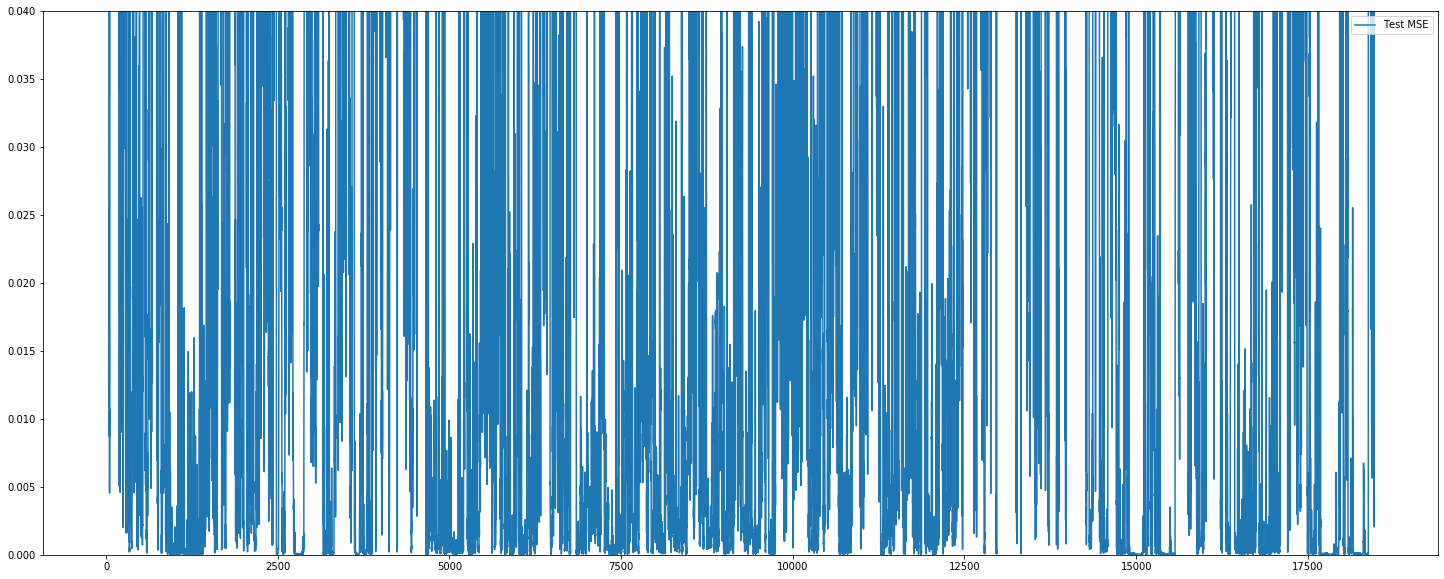

In [40]:
test_preds, test_errors = plot_test_error(model, x_test, y_test, title)

In [27]:
test_result = pd.read_csv("result/test_mse-{}.csv".format(title))
test_result

,Test MSE
0,0.054187
1,0.058388
2,0.056222
3,0.435066
4,0.818378
...,...
18464,0.003209
18465,0.007095
18466,0.006464
18467,0.002053


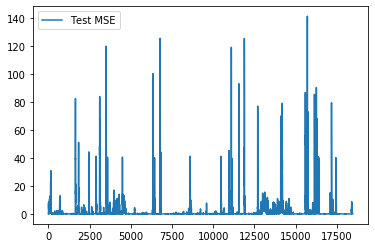

In [28]:
test_result.plot()

In [31]:
test_result.describe()

,Test MSE
count,18469.000000
mean,1.756262
std,7.901896
min,0.000009
25%,0.000795
50%,0.010050
75%,0.082764
max,141.366834


In [61]:
prediction_delta = std_scaler.inverse_transform(test_preds)
prediction_delta.shape

(18469, 1, 8)

In [59]:
data.loc[190000+16+4] - data.loc[190000+16]

SEG    49647494
dtype: int64

In [60]:
prediction_delta[0][0][0].astype(np.int64)

8838673

In [63]:
for i in range(8):
    real_delta = data.loc[190000+16+4+i] - data.loc[190000+16+i]
    pred_delta = prediction_delta[0][0][i].astype(np.int64)
    print(real_delta, pred_delta)

SEG    49647494
dtype: int64 8838673
SEG    50610416
dtype: int64 95898880
SEG   -458615584
dtype: int64 -207920768
SEG    25133414
dtype: int64 106096416
SEG   -10666118
dtype: int64 105089696
SEG    459763376
dtype: int64 -32311726
SEG    383078224
dtype: int64 116072152
SEG    409206686
dtype: int64 7341956


In [105]:
sample = delta_slice(data.tail(28).copy().reset_index(drop=True), pattern_length)
sample_scaled = std_scaler.transform(sample)
sample_scaled

array([[ 0.1537845 ],
       [-0.0031923 ],
       [-0.17765495],
       [-0.01192268],
       [-0.02321459],
       [-0.21375751],
       [-0.180568  ],
       [-0.02704566],
       [-0.17342839],
       [ 0.01139646],
       [-0.02351833],
       [-0.00815863],
       [-0.01701498],
       [ 0.00816095],
       [-0.00642751],
       [ 0.00272364],
       [-0.00235859],
       [-0.02230779],
       [ 0.03662029],
       [ 0.01024998],
       [ 0.00396554],
       [ 0.01649197],
       [-0.02612273],
       [ 0.01120565]])

In [111]:
x_sample = sample_scaled[:16].reshape(1, -1, 1)
y_sample = sample_scaled[16:]

In [114]:
y_sample_pred = model.predict(x_sample)

In [119]:
y_sample = std_scaler.inverse_transform(y_sample)
y_sample_pred = std_scaler.inverse_transform(y_sample_pred)

for i in range(8):
    print("Y : ", int(y_sample[i]))
    print("Pred : ", int(y_sample_pred[0][i]))
    print("Discrepency :", int(y_sample[i] - y_sample_pred[0][i]))

Y :  -56438230084340416646217728
Pred :  85208397791911954459131904
Discrepency : -141646627876252371105349632
Y :  -533824730086109558343729152
Pred :  -5977010251827954298388480
Discrepency : -527847719834281604045340672
Y :  876330881532456136769273856
Pred :  152515171244236548262068224
Discrepency : 723815710288219588507205632
Y :  245286399666242732811091968
Pred :  485091815297051233699758080
Discrepency : -239805415630808500888666112
Y :  94898983957986151229292544
Pred :  203995901883287395882762240
Discrepency : -109096917925301244653469696
Y :  394657782939634169735544832
Pred :  59257896387270868291551232
Discrepency : 335399886552363301443993600
Y :  -625116695928551956153368576
Pred :  -253487778363287174486425600
Discrepency : -371628917565264781666942976
Y :  268155632926035598370668544
Pred :  -612888054334611803443560448
Discrepency : 881043687260647333094752256
